
# Anomaly Detection Algorithm using Gaussian Mixture Model 



##Part 1: Getting started [6 Marks]

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Look at the dataset and we will answer the following questions.

* How many rows are there?
* What features in the dataset are present aside from the 28 main features? 
* Which column contains the targets? To what do the values correspond?

In [1]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=8424f1bfb62abb793e4041980cc41f0d7056574c0ebc366d2fbbe53b7ea55ae4
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [3]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')
df['rows']= np.arange(0,df['V23'].values.shape[0],1)

In [5]:

print('* How many rows are there?')
print(df.shape[0])
print('* What features in the dataset are present aside from the 28 main features?')
df.columns
print('time, amount')

print('* Which column contains the targets? To what do the values correspond?')
df['Class'].unique()
print('column "Class" contains the targets, 0 = non-fraudulent, 1 = fraudulent')

* How many rows are there?
284807
* What features in the dataset are present aside from the 28 main features?
time, amount
* Which column contains the targets? To what do the values correspond?
column "Class" contains the targets, 0 = non-fraudulent, 1 = fraudulent


In [6]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,rows
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,2
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,3
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,284802
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,284803
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,284804
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,284805


It's important when looking at a new dataset to figure out how many examples we have for each class.

* What is the percentage of entries in the dataset for each class? _____
* Is this data considered balanced or unbalanced? Why is this the case?_____
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? _____



In [7]:

print('positive : %f %%' % (df[df['Class']==1].shape[0]/df.shape[0] * 100))
print('negative : %f %%' % (df[df['Class']==0].shape[0]/df.shape[0] * 100))

positive : 0.172749 %
negative : 99.827251 %


* The data is inbalanced because there are a lot more negative cases  compared to positive cases. A balanced data should have a ratio of 50% between positive and negative
* Unbalanced dataset result a false prediction accuracy as most data belongs to one class. Data can be overfitted to one class and ignore the other class.
* KNN classifies class based on a majority of vote. if number of negatives outweights positive, the prediction will always result a negative, which is not true. 

---

Next, split the dataset into a training and testing set, and apply gaussian distribution to a single feature v11. 

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'Time':'Amount'], df['Class'], test_size=0.33, random_state=1)

In [0]:
from scipy import stats

norm = stats.norm(

    loc = df['V11'].mean(axis=0),  ## MEAN OF V11 
    scale = df['V11'].std(axis=0) ## STANDARD DEVIATION OF V11

)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


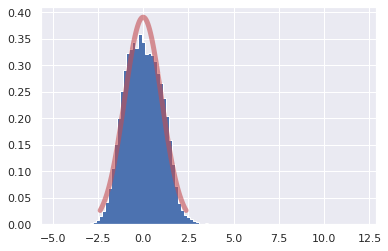

mean 0.00044933624793197204
std 1.0224359436549737


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.gridspec as gridspec

var_name = 'V11'

fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train[var_name].values, density=True, histtype='stepfilled', bins=100);
plt.show()

print('mean', X_train['V11'].mean())
print('std', X_train['V11'].std())

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

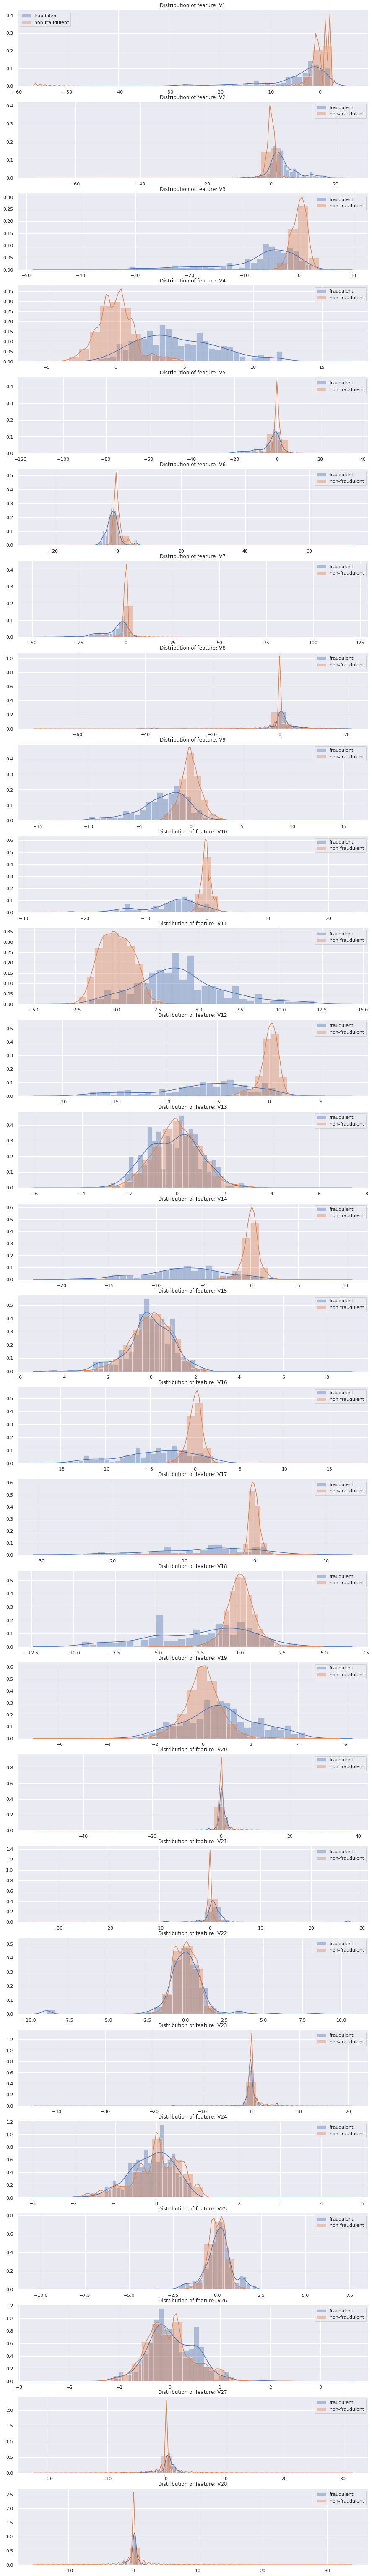

In [11]:
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

**Q.** Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[2 Marks]**

**Type your answer here**


Guassin model essential calcualtes data's mean and standard deviation to predict data. 

For feaures that have two non-overlapping gussian curves, we can make prediction by distinguishing which guassian curve the data fit in. 

These graphs can tell us which features is useful, therefore it is meaningful for feature selection.

## Part 2: Single Variable Gaussian Distribution: 
We'll start by making a prediction using **a single feature of our dataset at a time**. Let's explore the following scenarios:

1.   **One Gaussian:** First, we will fit a single gaussian distribution.

  *   Plot a ROC curve for each feature, fitting non-fraudulent transactions.
  *   Find the best feature to distinguish fraudulent transactions from non-fraudulent transactions based on AUC (Area under the ROC Curve)
  *  To make a prediction, we compute the probability that each transaction in the training set belongs to that distribution. If the probability is lower than a threshold, we consider that transaction a fraud. Find an optimal threshold that maximizes the F1 Score in the training set. 
  


2.   **Two Gaussians:** In this case, we will fit a Gaussian to each class in the selected feature above — one gaussian to the feature of non-fraudulent transactions and one gaussian for fraudulent transactions. To make predictions, we use the probability of a transaction belonging to the fraudulent Gaussian distribution and non-fraudulent distribution. 

  * Build a classifier using this two-gaussian approach on the training set, and once complete, test performance on the test set.



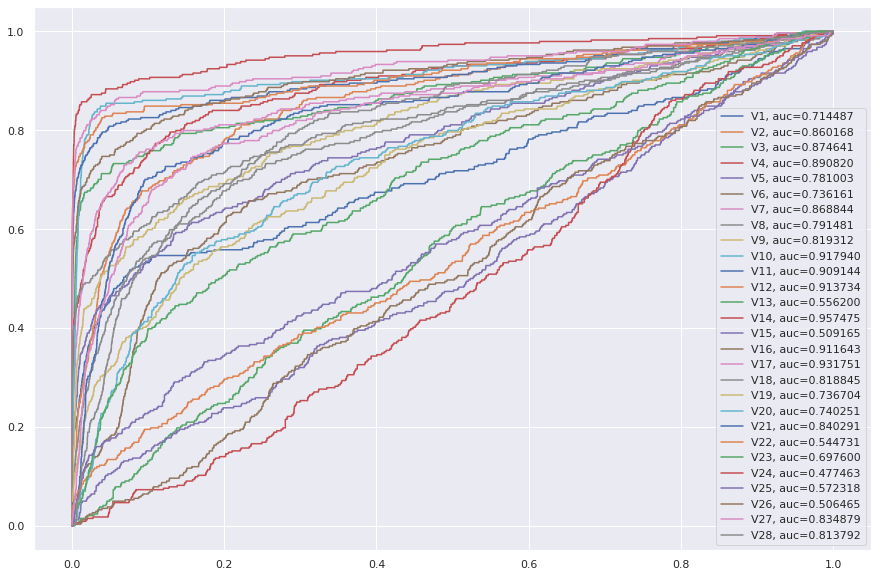

In [12]:
# # One Gaussian 

from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#single gaussian
gm = GaussianMixture(n_components = 1,covariance_type = 'full', random_state=0)


features=[f for f in X_train.columns if 'V' in f]
nplots=np.size(features)

plotsPerRow = 4
plt.figure(figsize=(15, 10))

fprs = []
tprs = []
aucs = []
# plot ROC of each feature
for i, feat in enumerate(features):
    X = X_train[feat][y_train==0].values.reshape(-1,1) #fitting non-fraudulent transactions
    gm.fit(X)
    p = gm.score_samples(X_train[feat].values.reshape(-1,1))
    fpr_sc, tpr_sc, _ = roc_curve(y_train, 1-p)
    auc = roc_auc_score(y_train, 1-p)

    plt.plot(fpr_sc, tpr_sc, label = '%s, auc=%f' % (feat,auc))
    plt.legend(loc='best')

    fprs.append(fpr_sc)
    tprs.append(tpr_sc)
    aucs.append(auc)

In [13]:

aucs_df = pd.DataFrame(np.array(aucs).reshape(-1,1))
aucs_df.columns = ['auc']
aucs_df['feature v#'] = np.arange(len(aucs),dtype='int')+1 
aucs_df.sort_values(by='auc', ascending=False).head(5)

# best feature is v14 with highest auc

,auc,feature v#
13,0.957475,14
16,0.931751,17
9,0.917940,10
11,0.913734,12
15,0.911643,16


In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#fit gm using feature V14
X = X_train['V14'].values.reshape(-1,1)
gm.fit(X)
p = gm.score_samples(X)

f1_sc = np.empty((0,4))

# calculate f1 scores
for i in range(1,200): 
   mn = sorted(p)[i] 
   precision = precision_score(y_train, p < mn) 
   recall = recall_score(y_train, p < mn)
   f1 = 2*(precision*recall)/(precision+recall)
   f1_sc = np.append(f1_sc, np.array([[i,f1, precision, recall]]), axis=0)


In [15]:
# finding optimal threshold that results the highest f1 score
f1_scs = pd.DataFrame(f1_sc, columns = ['k', 'F1', 'precision', 'recall'])
f1_scs[f1_scs.F1 == f1_scs.F1.max()]

,k,F1,precision,recall
197,198.0,0.557196,0.762626,0.438953


In [16]:
# test performance
from sklearn.metrics import accuracy_score

p_test = gm.score_samples(X_test['V14'].values.reshape(-1,1))
thres = sorted(p_test)[np.argmax(f1_scs.F1)]
pred = p_test<thres

accuracy = accuracy_score(y_test, pred)
print('accuracy: {}'.format(accuracy))

precision = precision_score(y_test, p_test < thres) 
recall = recall_score(y_test, p_test < thres)
f1 = 2*(precision*recall)/(precision+recall)
print('f1: {}, precision: {}, recall: {}'.format(f1, precision, recall))

accuracy: 0.9983295562152212
f1: 0.5449275362318841, precision: 0.47715736040609136, recall: 0.6351351351351351


Accuracy matches the percentage of non-fradualent cases, indicating model is simply identifying all cases as non-fradulent. Therefore this is a fake accuracy resulted from unbalanced data

F1 is a better performance metrics, but score of 0.544 is not ideal.



In [17]:
# Two Gaussians

# with unbalanced data, the guassian models are fitted seperately to make sure they are fitted to fradulent and non fradulent 
# using GaussainMixture with 2 components resulted skewed model both fitted around to non-fradulent.

feat = 'V14'

gm0 = GaussianMixture(n_components = 1) # fit to non-fraudulent
gm0.fit(X_train[feat][y_train == 0].values.reshape(-1,1))
gm1 = GaussianMixture(n_components = 1) # fit to fraudulent
gm1.fit(X_train[feat][y_train == 1].values.reshape(-1,1))
print('class 0 mean: {}, std: {}'.format(gm0.means_, np.sqrt(gm0.covariances_)))
print('class 1 mean: {}, std: {}'.format(gm1.means_, np.sqrt(gm1.covariances_)))
#distribution shaped similar to part 1 

p0 = gm0.score_samples(X_test[feat].values.reshape(-1,1))
p1 = gm1.score_samples(X_test[feat].values.reshape(-1,1))
# p1 and p2 are probabilities of belong to class 0 and 1 
# if p1>p0, then the prediction is class 1, a fraudulent transaction
p_gm2 = p1>p0

print('accuracy:',accuracy_score(y_test,p_gm2))

precision = precision_score(y_test, p_gm2) 
recall = recall_score(y_test, p_gm2)
f1 = 2*(precision*recall)/(precision+recall)
print('f1: {}, precision: {}, recall: {}'.format(f1,precision, recall))

class 0 mean: [[0.00989609]], std: [[[0.89715975]]]
class 1 mean: [[-7.10716824]], std: [[[4.26390716]]]
accuracy: 0.9706980752657283
f1: 0.082, precision: 0.043127629733520335, recall: 0.831081081081081


* Result good recall but horrible precision, meaning there are less false negative, fewer fraud are undetected.
* There are also many false positive, so many non-fraudulent transactions are marked as fraud. 
* The resuilt shows effect of fitting one of the Gaussian to the fradulent data, it increases weight of fradulent data, so model is making more class 1 predictions.
* In the context of creditcard transaction, we would want higher recall more than higher precision because it is more important to catch a fraud than having a false alarm

## Part 3: Multivariate and Mixture of Gaussian Distribution [7 Marks]
We want to build an outlier detection model that boosts our F1 score compared to the last part. To design the model, we can benefit from:

*   Any number of features (multivariate).
*   Fit  Gaussians only on non-fraudulent transactions or to both classes.

The following tries 5 different models to find the best model. 




### Testing models based on the following categories
* prediction vs threshold 
 * predict: assign p_score to each component (fraud or non-fraud), classify data to the component with highest p_score 
 * threshold: p_score under a certain threshold are outliers 


* fit to non-fradulent or both 
* Number of features 
* Number of components
---








In [0]:
# function to calculate model performance
def testPerformance(y_true, y_pred, printLn=True): 

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred) 
  recall = recall_score(y_true, y_pred)
  f1 = 2*(precision*recall)/(precision+recall)

  if printLn: 
    print('accuracy: {}, precision: {}, recall: {}, f1: {}'.format(accuracy, precision, recall, f1))
  return accuracy, precision, recall, f1

starting with all features, testing between fitting non-fadulent or both classes

### model 1:
* fit two components, then one component should repressent fradulent, another should represent non-fradulent 
* evaluate p_score to each component, assign data to component with highest p_score
* train and test with all features 


In [74]:
gm = GaussianMixture(n_components = 2, random_state=0)
gm.fit(X_train)

p = gm.predict(X_test)
preformance = testPerformance(y_test,p)

accuracy: 0.3341632353410578, precision: 0.0021371610845295056, recall: 0.9054054054054054, f1: 0.004264256619144603


Model performed horribly in all metrics. Since the data is unbalanced, The two components are not fitted to fradulent or non-fradulent. 
The number of non-fradulent data is overpowering the number of fradulent data, so the gaussain moodel is biased towards non-fradulent. 

This is not the model to use.

---



### model 2 

* Try to balance the data by upsampling the fraudulent set, then there can be equal number of data from both classes.
* 2 components guassian, one fits to non-fradulent, one fits to fradulent
* train and test with all features



In [73]:
# upsample minority class 
from sklearn.utils import resample


X_train_0 = X_train[y_train == 0].copy()
X_train_1 = X_train[y_train == 1].copy()


X_train_1_upsampled = resample(X_train_1,
                             replace=True,  
                             n_samples=X_train_0.shape[0],  
                             random_state=0)  
X_train_upsampled = pd.concat([X_train_0, X_train_1_upsampled])

gm = GaussianMixture(n_components = 2, random_state=0)
gm.fit(X_train_upsampled['V14'].values.reshape(-1,1))

p = gm.predict(X_test['V14'].values.reshape(-1,1))
preformance = testPerformance(y_test,p)


print('component 1: mean {}, std {}'.format(gm.means_[0], np.sqrt(gm.covariances_)[0] ) )
print('component 2: mean {}, std {}'.format(gm.means_[1], np.sqrt(gm.covariances_)[1] ) )

accuracy: 0.9508761850043091, precision: 0.026689260749841136, recall: 0.8513513513513513, f1: 0.051756007393715345
component 1: mean [0.03014218], std [[0.72054612]]
component 2: mean [-7.13256897], std [[4.27716197]]


Aftering upsampling, the two guassain indeed represents the two classes, shown by the mean and std. Recall has improved drastically, but precision is still bad. The fradulent gaussin has a high standard deviation of 4.2, this could be why the model still performs poorly because the fradulent variance is too high, creates too many false positive cases. 

---


### model 3
* fitting only non-fraudulent data, then p-score represents the likelyhood of the data belong to non-fradulent data.
* use a threshold to classify whether the data should belong to non-fraudulent, outliers are classifed as fraud
* single gaussain
* train and test with all features


In [72]:
gm = GaussianMixture(n_components = 1, random_state=0)
gm.fit(X_train[y_train == 0])
p = gm.score_samples(X_train)


def findThres(y_true, p): 
  
  # finding optimal threshold 
  # define first k ascending probability as anomalous
  # use percentile instead of sort for faster calculation 
  q = np.arange(0.1,1,0.05) 
  thres = np.percentile(p, q)
  f1 = 0
  t = 0
  for t_ in thres: 
    acc_, precision_, recall_, f1_ = testPerformance(y_true, p<t_, printLn=False)
    if f1_ < f1: 
      return t     
    t = t_
    f1 = f1_


thres = findThres(y_train, p)
print('thres = ', thres)

# testing on test data
p = gm.score_samples(X_test)
preformance = testPerformance(y_test, p<thres)


thres =  -649.3839923970887
accuracy: 0.9983082766765616, precision: 0.46706586826347307, recall: 0.527027027027027, f1: 0.4952380952380952


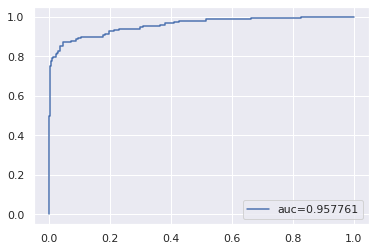

In [0]:
# plot ROC
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
auc = roc_auc_score(y_test, 1-p)

plt.plot(fpr_sc, tpr_sc, label = 'auc=%f' % auc)
plt.legend(loc='best')

Performace is improved from last two model with a much higher f1, meaning this model is on the right track. Now tweak parameters.

### model 4

repeat model 3 but tweek number of components fitting non-fraudulent data

* n-components
* threshold method fitted to non-fraud, outliers are fraud
* train and test with all features

Number of components 1
accuracy: 0.9983082766765616, precision: 0.46706586826347307, recall: 0.527027027027027, f1: 0.4952380952380952
Number of components 2
accuracy: 0.9990530605296477, precision: 0.6855345911949685, recall: 0.7364864864864865, f1: 0.7100977198697068
Number of components 3
accuracy: 0.9983614755232106, precision: 0.4819277108433735, recall: 0.5405405405405406, f1: 0.5095541401273885
Number of components 4
accuracy: 0.9986593890644451, precision: 0.569620253164557, recall: 0.6081081081081081, f1: 0.5882352941176471
Number of components 5
accuracy: 0.9989147435283603, precision: 0.6949152542372882, recall: 0.5540540540540541, f1: 0.6165413533834587


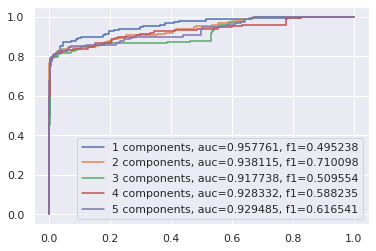

In [0]:

for n in range(1,6):
  print('Number of components', n)
  gm = GaussianMixture(n_components = n, random_state=0)
  # gm.fit(X_train.iloc[:,feat][y_train == 0])
  gm.fit(X_train[y_train == 0])


  # p = gm.score_samples(X_train.iloc[:,feat])
  p = gm.score_samples(X_train)


  # find threshold
  thres = findThres(y_train, p)

  # testing on test data
  # p = gm.score_samples(X_test.iloc[:,feat])
  p = gm.score_samples(X_test)
  acc, precision, recall, f1 = testPerformance(y_test, p<thres)

  # plot ROC
  fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
  auc = roc_auc_score(y_test, 1-p)

  plt.plot(fpr_sc, tpr_sc, label = '%d components, auc=%f, f1=%f' % (n, auc, f1))
  plt.legend(loc='best')



2 components results the best performce at f1 = 0.71

### model 5

Fine tune model 4 with feature selection

* 2-components fitted to non-fraudulent data 
* threshold method, outliers are fraud 
* train and test with selected number of features


 f1 = 0.742671009771987 with 16 features:  ['V14' 'V17' 'V10' 'V12' 'V16' 'V11' 'V4' 'V3' 'V7' 'V2' 'V21' 'V27' 'V9'
 'V18' 'Time' 'Amount']


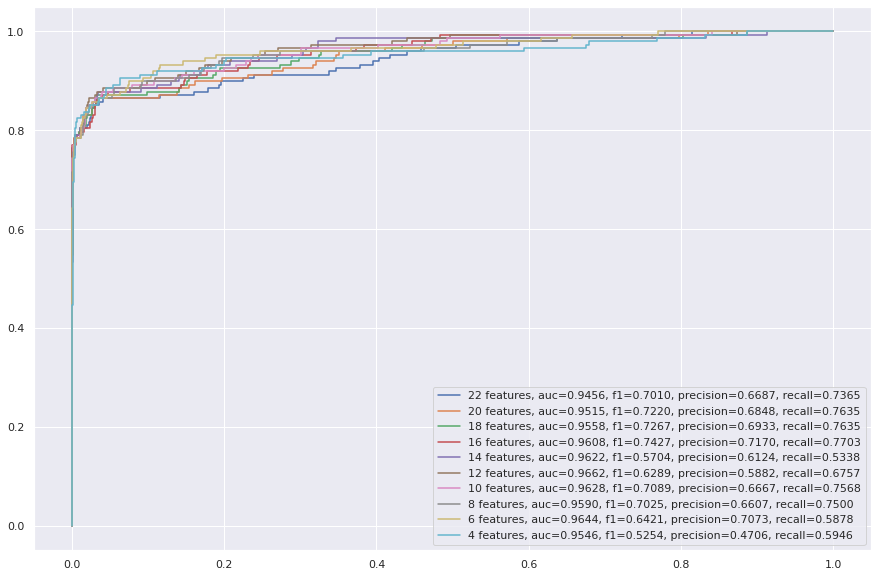

In [0]:
feat = []
f1_ = 0
plt.figure(figsize=(15, 10))

for i in range(20,0,-2):
  # eliminate feature with low auc  
  feat_rd = aucs_df.sort_values(by='auc', ascending=False).head(i)
  feat_rd = feat_rd['feature v#'].values
  feat_rd = np.append(feat_rd,[0,-1])

  # print('Number of features:', X_train.iloc[:,feat_rd].shape[1])

  gm = GaussianMixture(n_components = 2, random_state=0)
  gm.fit(X_train.iloc[:,feat_rd][y_train == 0])
  p = gm.score_samples(X_train.iloc[:,feat_rd])

  # find threshold
  thres = findThres(y_train, p)

  # testing on test data
  p = gm.score_samples(X_test.iloc[:,feat_rd])
  acc, precision, recall, f1 = testPerformance(y_test, p<thres, printLn=False)

  # find best features that scores highest f1
  if f1 >= f1_: 
    f1_ = f1
    feat = feat_rd

  # plot ROC
  fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
  auc = roc_auc_score(y_test, 1-p)

  plt.plot(fpr_sc, tpr_sc, 
           label = '%d features, auc=%.4f, f1=%.4f, precision=%.4f, recall=%.4f' 
           %(feat_rd.shape[0], auc, f1, precision, recall))

plt.legend(loc='best')
# plt.ylim(bottom=0.6)


print('\n f1 = {} with {} features:  {}'.format(f1_, feat.shape[0], X_train.iloc[:,feat].columns.values))


In [0]:

print('selected features:', X_train.iloc[:,feat].columns.values)

gm = GaussianMixture(n_components = 2, random_state=0)
gm.fit(X_train.iloc[:,feat][y_train == 0])
p = gm.score_samples(X_train.iloc[:,feat])
thres = findThres(y_train, p)
print('thres:', thres)
p = gm.score_samples(X_test.iloc[:,feat])
acc, precision, recall, f1 = testPerformance(y_test, p<thres)


selected features: ['V14' 'V17' 'V10' 'V12' 'V16' 'V11' 'V4' 'V3' 'V7' 'V2' 'V21' 'V27' 'V9'
 'V18' 'Time' 'Amount']
thres: -236.6751052413619
accuracy: 0.9991594582229457, precision: 0.7169811320754716, recall: 0.7702702702702703, f1: 0.742671009771987


Best model. Highest f1 of 0.74 is reached with 16 features

In summary, the model is trained as follows:

* 2 components guassian fitted to only non-fradulent data
* outlier that has a log possibility score lower than threshold are fraudulent
* threshold = -305.71
* 16 features are selected: 
  * V14, V17,  V10, V12, V16, V11, V4, V3, V7, V2, V21, V27, V9, V18, V28, V8, V5, Time, Amount
